In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob
from typing import List
import shutil
import seaborn as sns


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

In [6]:
a = os.listdir('/kaggle/input/durum-wheat-dataset/Durum_Wheat_Dataset/Dataset2-Durum Wheat Video Images')

In [7]:
a

['3-Images from Foreign Matters',
 '1-Images from Vitreous Durum Wheat',
 '2-Images from Starchy Durum Wheat',
 '5-Images form Mixture of All Durum Wheat and Foreign Matters (Labeled)',
 '4-Images from Mixture of All Durum Wheat and Foreign Matters']

In [8]:
#creating a dictionary for labels
l = {'1':"Vitreous",'2':"Starchy",'3':"Foreign matters", "4":"Wheat Foreign matters", "5":"Wheat Foreign matters 1"}

In [9]:
labels = []
filepaths = []

In [10]:
#creating a dataframe with labels and paths
for i in a:
    c = '/kaggle/input/durum-wheat-dataset/Durum_Wheat_Dataset/Dataset2-Durum Wheat Video Images/'+ str(i)
    x = os.listdir(c)
    
    if i[0] not in l:
        continue
    
    for j in x:
        d = c + '/' + str(j)
        filepaths.append(d)
        labels.append(l[i[0]])

In [11]:
label_series = pd.Series(labels, name="labels")
filepaths_series = pd.Series(filepaths, name="filepaths")

In [12]:
df = pd.concat([filepaths_series, label_series],axis=1)

In [13]:
df['labels'].value_counts()

labels
Foreign matters            65
Vitreous                   65
Starchy                    65
Wheat Foreign matters 1    65
Wheat Foreign matters      65
Name: count, dtype: int64

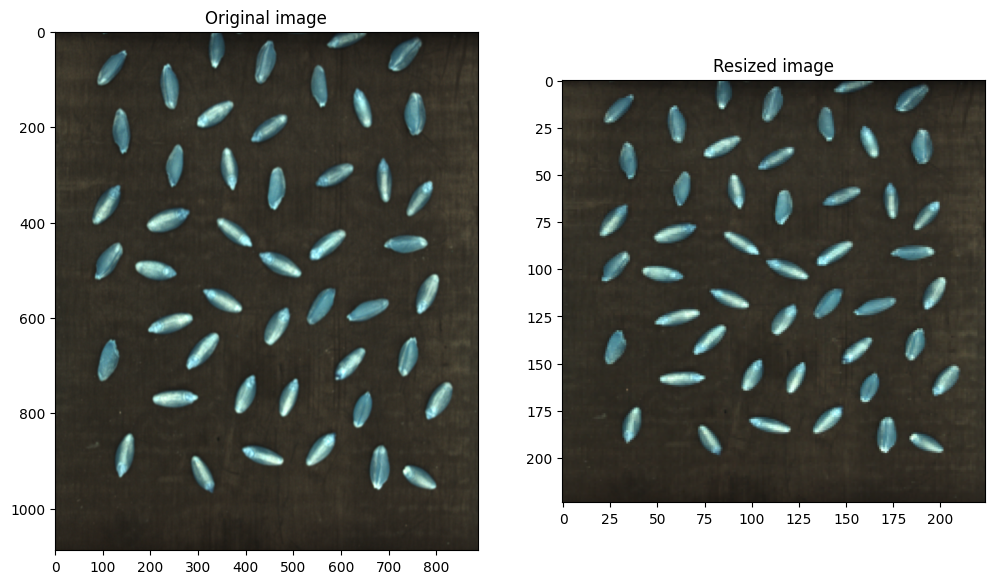

In [13]:
img = cv2.imread("/kaggle/input/durum-wheat-dataset/Durum_Wheat_Dataset/Dataset2-Durum Wheat Video Images/1-Images from Vitreous Durum Wheat/Frame 0001.tif")
image_resized = cv2.resize(img, (224,224))

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img); ax[0].set_title('Original image')
ax[1].imshow(image_resized); ax[1].set_title('Resized image')
plt.show()

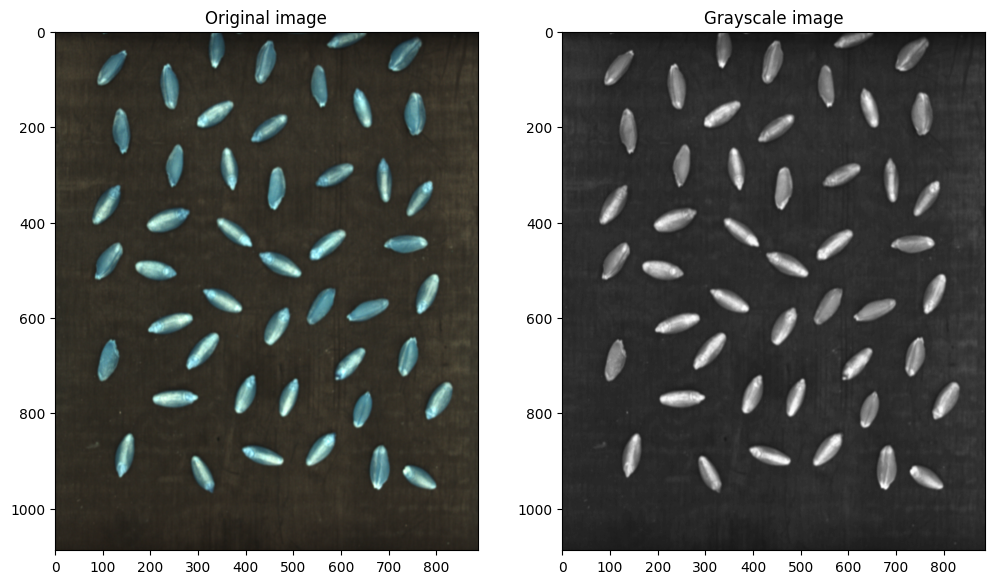

In [14]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img); ax[0].set_title('Original image')
ax[1].imshow(img_gray,cmap='gray', vmin = 0, vmax = 255); ax[1].set_title('Grayscale image')
plt.show()

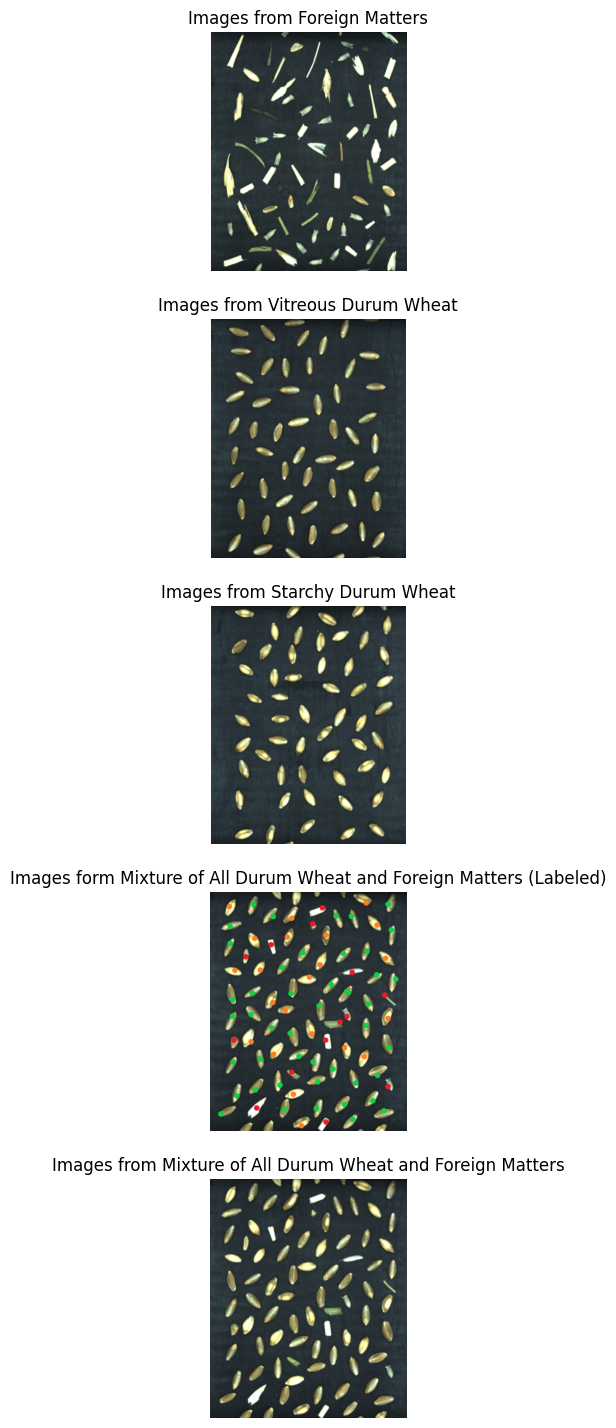

In [15]:
d = '/kaggle/input/durum-wheat-dataset/Durum_Wheat_Dataset/Dataset2-Durum Wheat Video Images/'
plt.figure(figsize=(18, 18))
k=0
for i in os.listdir(d):
    image = os.listdir(d+i)[0]
    Image.open(d+i+'/'+image)
    ax=plt.subplot(5,1,k+1)
    k=k+1
    plt.title(i[2:])
    plt.axis("off")
    plt.imshow(Image.open(d+i+'/'+image))

In [14]:
datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5),
        validation_split=0.4)

In [ ]:
new_img = cv2.flip(img,0)
new_img.shape

In [18]:
#using data augmentation to create more diverse dataset
#images per class increased from to 65 to 390

In [15]:
for cls in a:
    os.mkdir('/kaggle/working/' + '/' + cls)

In [16]:
train_dir = '/kaggle/input/durum-wheat-dataset/Durum_Wheat_Dataset/Dataset2-Durum Wheat Video Images'
new_train_dir = '/kaggle/working/'

In [17]:
x = {
     "Foreign matters":"3-Images from Foreign Matters",
     "Vitreous":"1-Images from Vitreous Durum Wheat",
     "Starchy":"2-Images from Starchy Durum Wheat",
     "Wheat Foreign matters":"5-Images form Mixture of All Durum Wheat and Foreign Matters (Labeled)",
     "Wheat Foreign matters 1":"4-Images from Mixture of All Durum Wheat and Foreign Matters"
}

In [19]:
#adding random flip, brightness, crop and rotation to images
k=0
for i in range(len(df)):
    src_path = str(df.iloc[i,0])
    dst_path = new_train_dir + str(x[df.iloc[i,1]])
    img = cv2.imread(src_path)
    
    img_l = np.array(tf.image.random_flip_left_right(img))
    img_h = np.array(tf.image.random_flip_up_down(img))
    img_b = np.array(tf.image.random_brightness(img, 0.2))
    img_c = np.array(tf.image.random_crop(value = img, size=(224, 224, 3)))
    img_r = np.array(tf.keras.preprocessing.image.random_rotation(img, 90, row_axis=0, col_axis=1,channel_axis=2))
    
    cv2.imwrite((new_train_dir + str(x[df.iloc[i,1]]) + '/' + 'new' + str(k) + '.tif'),img_l)
    k=k+1
    cv2.imwrite((new_train_dir + str(x[df.iloc[i,1]]) + '/' + 'new' + str(k) + '.tif'),img_h)
    k=k+1
    cv2.imwrite((new_train_dir + str(x[df.iloc[i,1]]) + '/' + 'new' + str(k) + '.tif'),img_b)
    k=k+1
    cv2.imwrite((new_train_dir + str(x[df.iloc[i,1]]) + '/' + 'new' + str(k) + '.tif'),img_c)
    k=k+1
    cv2.imwrite((new_train_dir + str(x[df.iloc[i,1]]) + '/' + 'new' + str(k) + '.tif'),img_r)
    k=k+1
    
    shutil.copy(src_path,dst_path)

In [20]:
labels = []
filepaths = []

for i in a:
    c = '/kaggle/working/'+ str(i)
    x = os.listdir(c)
    
    if i[0] not in l:
        continue
    
    for j in x:
        d = c + '/' + str(j)
        filepaths.append(d)
        labels.append(l[i[0]])

label_series = pd.Series(labels, name="labels")
filepaths_series = pd.Series(filepaths, name="filepaths")

df1 = pd.concat([filepaths_series, label_series],axis=1)

In [21]:
df1['labels'].value_counts()

labels
Foreign matters            390
Vitreous                   390
Starchy                    390
Wheat Foreign matters 1    390
Wheat Foreign matters      390
Name: count, dtype: int64

In [22]:
X = df1 # Contains all columns.
y = df1[['labels']] # Dataframe of just the column on which to stratify.

In [23]:
#creating train and val splits
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=0.30,
                                                          random_state=40)

In [24]:
train_data = datagen.flow_from_dataframe(df_train,
                                                directory='/kaggle/working/',
                                                x_col = 'filepaths',
                                                y_col = 'labels',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'categorical',
                                                subset = 'training')

Found 819 validated image filenames belonging to 5 classes.


In [25]:
val_data = datagen.flow_from_dataframe(df_temp,
                                                directory='/kaggle/working/',
                                                x_col = 'filepaths',
                                                y_col = 'labels',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'categorical',
                                                subset = 'validation')

Found 234 validated image filenames belonging to 5 classes.


In [27]:
BATCH_SIZE = 32
IMG_SHAPE = (256, 256, 3)
num_classes = 5
LR = 0.0003
IMG_SHAPE_2 = (224, 224, 3)
# We create a Learning Rate Reducer that will reduce the learning rate by half if the validation loss does not decrease in 4 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose = 1)

# We stop the model training if we see no improvement (reduction in validation loss) for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

In [28]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

## EfficientNetV2M

In [51]:
eff_model = EfficientNetV2M(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
eff_model.trainable = False
eff_output = eff_model.output 

x = Flatten()(eff_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
eff_final_model = Model(eff_model.input, output)

214201816/214201816 [==============================] - 1s 0us/step


In [52]:
eff_final_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [54]:
history_efficientnet = eff_final_model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/10
26/26 [==============================] - 58s 2s/step - loss: 1.4699 - accuracy: 0.3370 - val_loss: 1.2930 - val_accuracy: 0.4402 - lr: 3.0000e-04
Epoch 2/10
26/26 [==============================] - 50s 2s/step - loss: 1.3094 - accuracy: 0.4420 - val_loss: 1.1128 - val_accuracy: 0.4872 - lr: 3.0000e-04
Epoch 3/10
26/26 [==============================] - 50s 2s/step - loss: 1.2017 - accuracy: 0.4725 - val_loss: 1.0681 - val_accuracy: 0.5043 - lr: 3.0000e-04
Epoch 4/10
26/26 [==============================] - 50s 2s/step - loss: 1.1252 - accuracy: 0.5092 - val_loss: 1.0176 - val_accuracy: 0.4957 - lr: 3.0000e-04
Epoch 5/10
26/26 [==============================] - 50s 2s/step - loss: 1.1334 - accuracy: 0.5067 - val_loss: 1.0620 - val_accuracy: 0.4658 - lr: 3.0000e-04
Epoch 6/10
26/26 [==============================] - 50s 2s/step - loss: 1.1007 - accuracy: 0.5311 - val_loss: 1.0422 - val_accuracy: 0.5085 - lr: 3.0000e-04
Epoch 7/10
26/26 [==============================] - 49s 2s

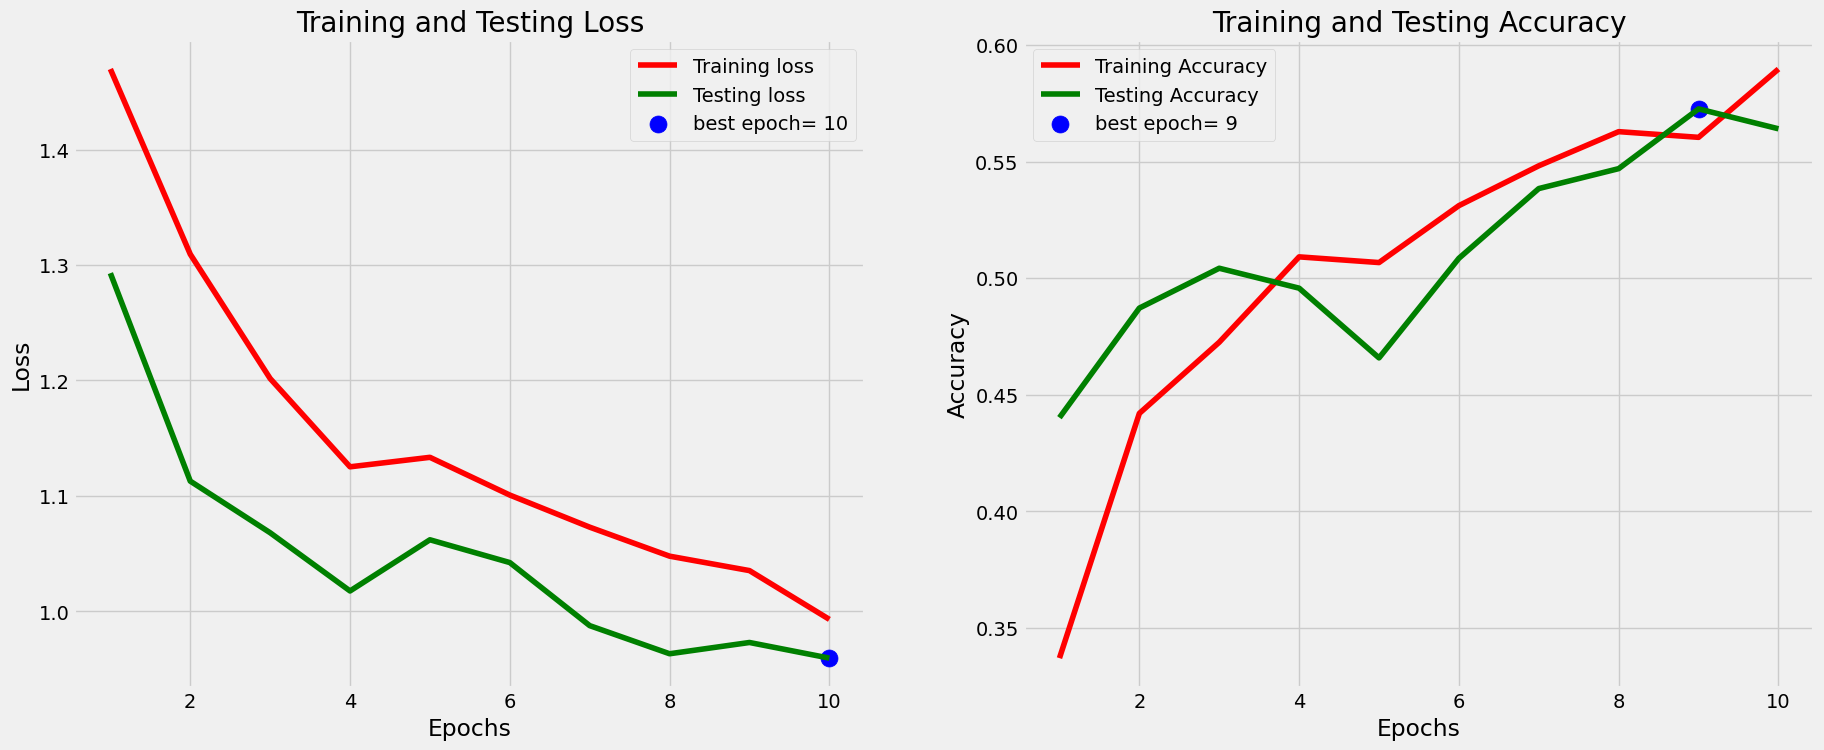

In [55]:
plot_training(history_efficientnet)

## InceptionV3

In [40]:
inception_model =  InceptionV3(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
inception_model_output = inception_model.output

x = Flatten()(inception_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='relu')(x)
inception_output = Dense(num_classes, activation='softmax')(x)
inception_final = Model(inception_model.input, inception_output)

In [48]:
inception_final.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [49]:
    history_inception = inception_final.fit(train_data, epochs=7, validation_data=val_data, callbacks=[early_stopping, reduce_lr])

Epoch 1/7
26/26 [==============================] - 58s 2s/step - loss: 0.6416 - accuracy: 0.6862 - val_loss: 1.1699 - val_accuracy: 0.6239 - lr: 3.0000e-04
Epoch 2/7
26/26 [==============================] - 49s 2s/step - loss: 0.4383 - accuracy: 0.7900 - val_loss: 0.3848 - val_accuracy: 0.7949 - lr: 3.0000e-04
Epoch 3/7
26/26 [==============================] - 50s 2s/step - loss: 0.4768 - accuracy: 0.7839 - val_loss: 0.4882 - val_accuracy: 0.7906 - lr: 3.0000e-04
Epoch 4/7
26/26 [==============================] - 50s 2s/step - loss: 0.4569 - accuracy: 0.7729 - val_loss: 0.7204 - val_accuracy: 0.7009 - lr: 3.0000e-04
Epoch 5/7
26/26 [==============================] - 50s 2s/step - loss: 0.4859 - accuracy: 0.7863 - val_loss: 0.5800 - val_accuracy: 0.7650 - lr: 3.0000e-04
Epoch 6/7
26/26 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8059
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
26/26 [==============================] - 50s 2s/ste

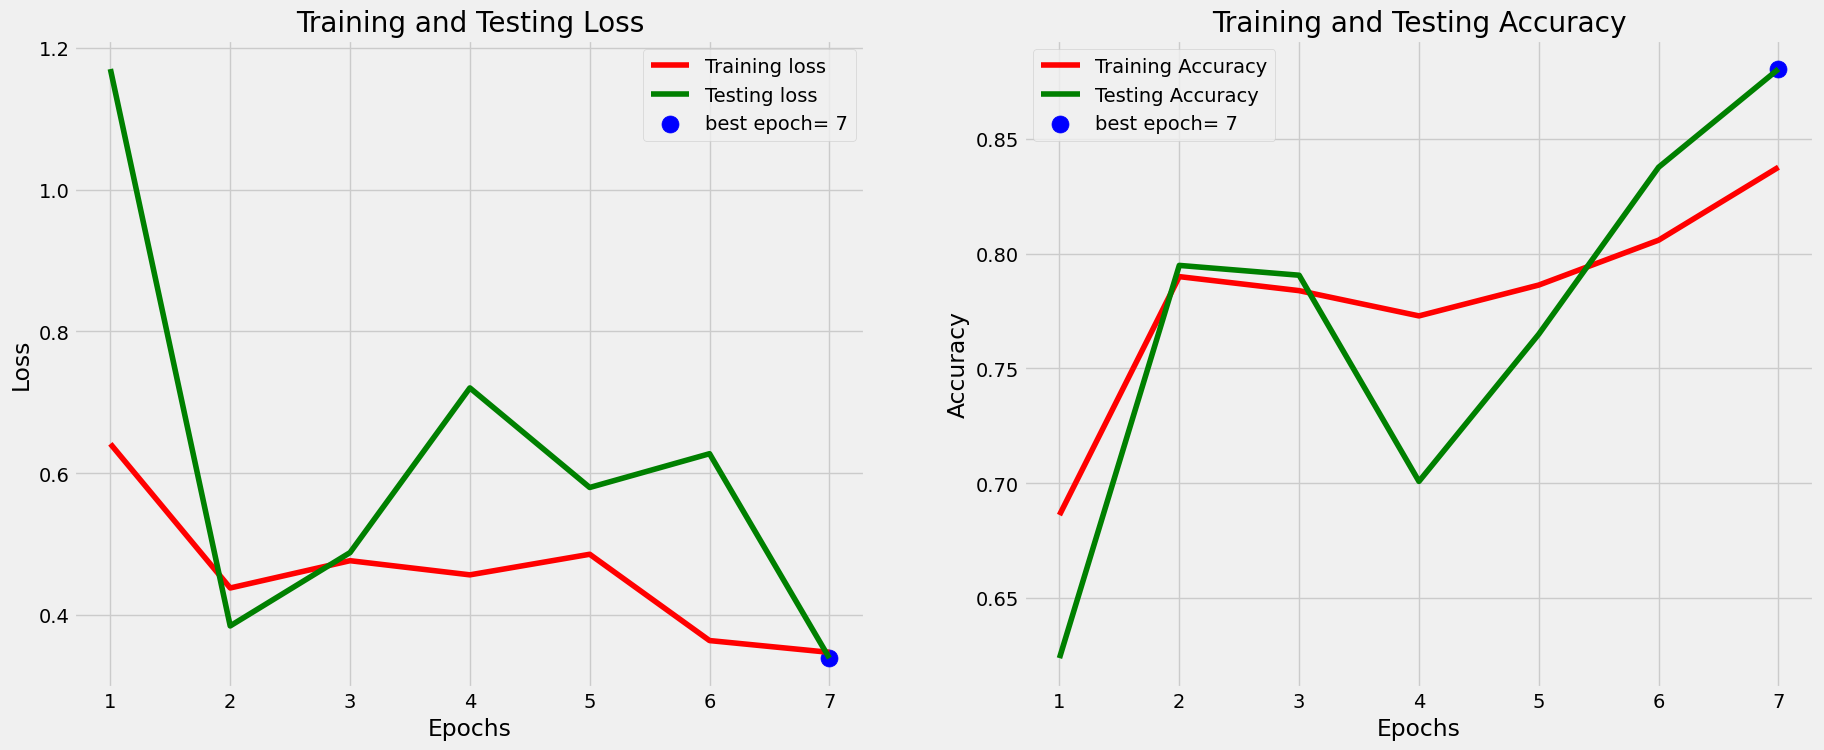

In [50]:
plot_training(history_inception)

## DenseNet121

In [69]:
densenet_model = DenseNet121(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
densenet_model_output = densenet_model.output

x = Flatten()(densenet_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='relu')(x)
densenet_out = Dense(num_classes, activation='softmax')(x)
densenet_m = Model(densenet_model.input, densenet_out)

In [70]:
densenet_m.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [72]:
history_densenet = densenet_m.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
26/26 [==============================] - 53s 2s/step - loss: 1.3201 - accuracy: 0.3871 - val_loss: 1.3228 - val_accuracy: 0.4060 - lr: 3.0000e-04
Epoch 2/10
26/26 [==============================] - 51s 2s/step - loss: 1.3055 - accuracy: 0.3858 - val_loss: 1.2875 - val_accuracy: 0.4188 - lr: 3.0000e-04
Epoch 3/10
26/26 [==============================] - 51s 2s/step - loss: 1.2983 - accuracy: 0.3932 - val_loss: 1.2999 - val_accuracy: 0.4103 - lr: 3.0000e-04
Epoch 4/10
26/26 [==============================] - 51s 2s/step - loss: 1.3123 - accuracy: 0.3968 - val_loss: 1.4615 - val_accuracy: 0.3248 - lr: 3.0000e-04
Epoch 5/10
26/26 [==============================] - 51s 2s/step - loss: 1.2725 - accuracy: 0.3980 - val_loss: 1.2865 - val_accuracy: 0.4188 - lr: 3.0000e-04
Epoch 6/10
26/26 [==============================] - 50s 2s/step - loss: 1.2752 - accuracy: 0.4005 - val_loss: 1.2810 - val_accuracy: 0.4188 - lr: 3.0000e-04
Epoch 7/10
26/26 [==============================] - 50s 2s

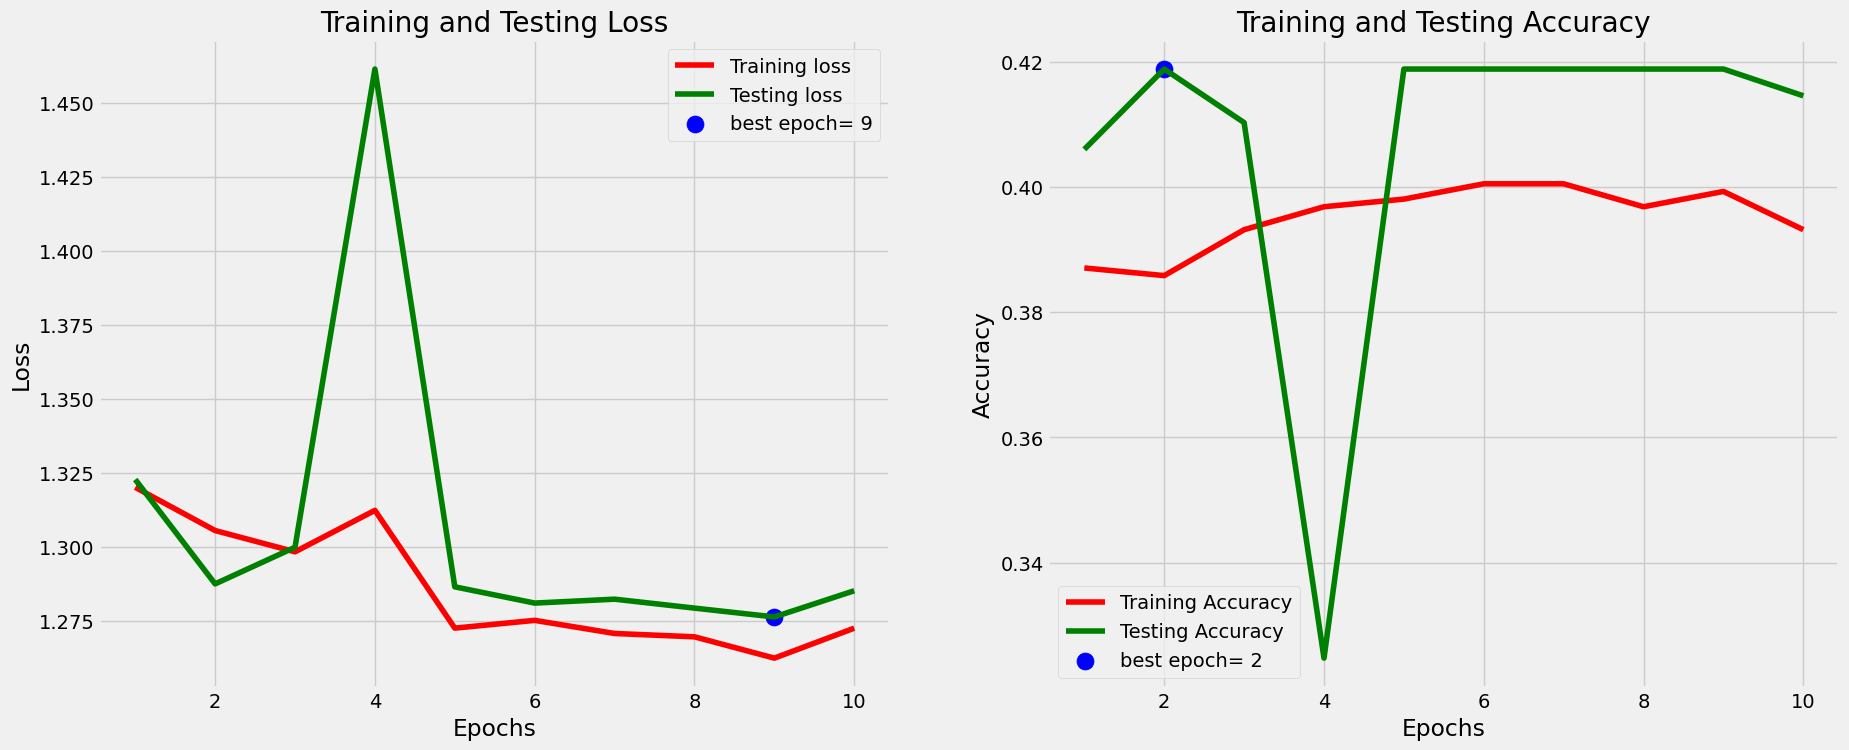

In [73]:
plot_training(history_densenet)

## ResNet50

In [29]:
model_ResNet =tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE_2,
    weights='imagenet'
)
model_ResNet.trainable = False

#adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_ResNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_ResNet = tf.keras.Model(inputs=[input_layer],outputs=[output])

94765736/94765736 [==============================] - 1s 0us/step


In [30]:
model_ResNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history_res = model_ResNet.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping, reduce_lr])

Epoch 1/10


I0000 00:00:1707182982.647248     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 63s 2s/step - loss: 38.1947 - accuracy: 0.6129 - val_loss: 3.9983 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - 52s 2s/step - loss: 2.8573 - accuracy: 0.8755 - val_loss: 0.9503 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - 53s 2s/step - loss: 1.0010 - accuracy: 0.9158 - val_loss: 0.9662 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - 52s 2s/step - loss: 0.9509 - accuracy: 0.9219 - val_loss: 0.8371 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 5/10
26/26 [==============================] - 52s 2s/step - loss: 0.6148 - accuracy: 0.9365 - val_loss: 0.3093 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 6/10
26/26 [==============================] - 52s 2s/step - loss: 0.4527 - accuracy: 0.9475 - val_loss: 0.1991 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 7/10
26/26 [==============================] - 52s 2s/step - loss: 0.5734 - accuracy: 0

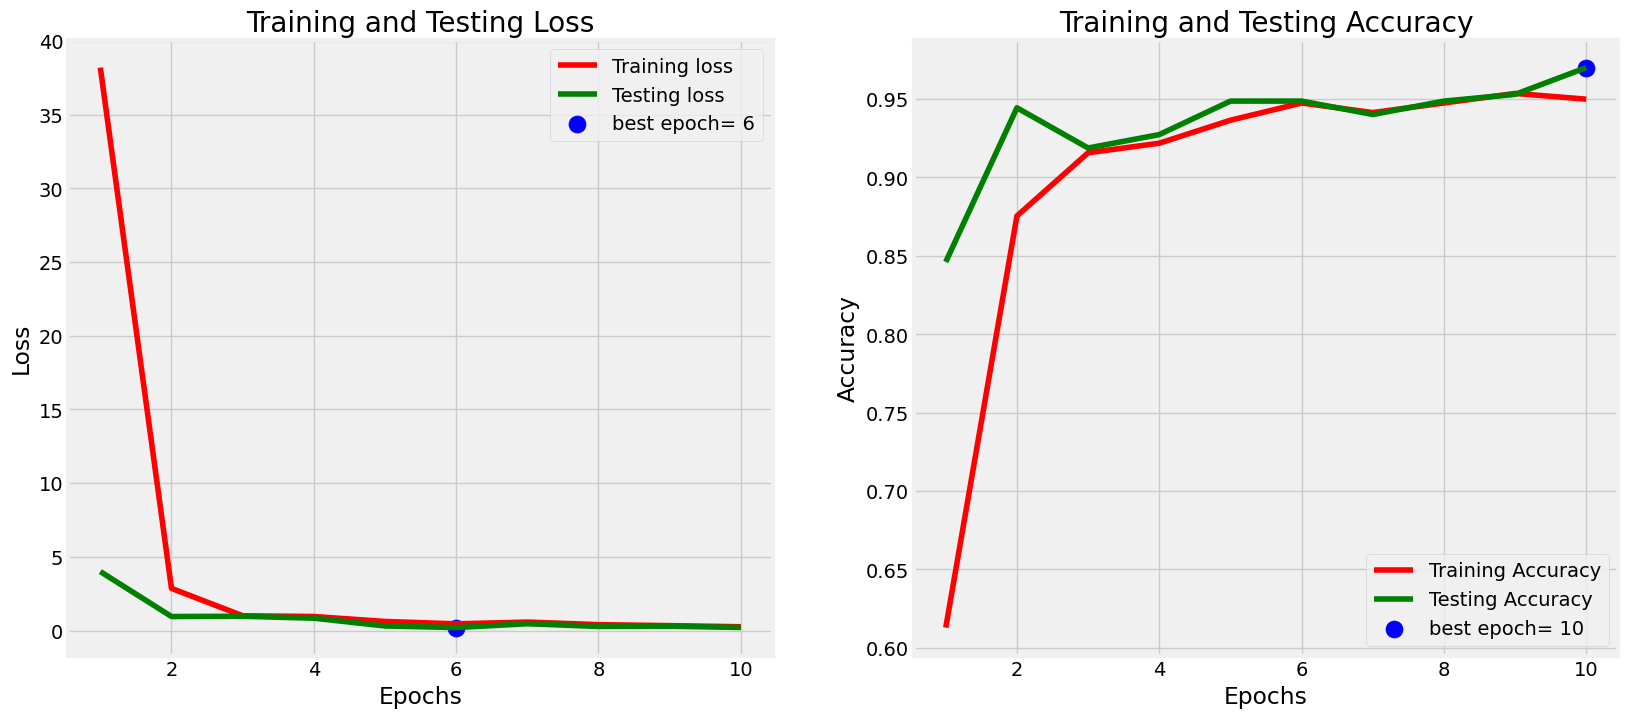

In [33]:
plot_training(history_res)